<a href="https://colab.research.google.com/github/mjtaheri11/digit-detector/blob/master/main_digit_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive" -a

in this task we locate and detect numbers with cnn 

---
this is also can be use for fully connected. just run the other network as model




In [ ]:
import numpy as np
import keras
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
from sklearn.feature_extraction.image import PatchExtractor
from skimage import exposure
import tensorflow as tf
import math
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from itertools import chain
from skimage import data, color, transform, feature
import sys, os
import cv2
from skimage.color import rgb2gray

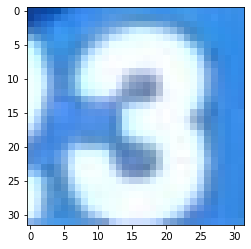

[3]
[0 0 1 0 0 0 0 0 0 0]
(109257, 11)
(26032, 11)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


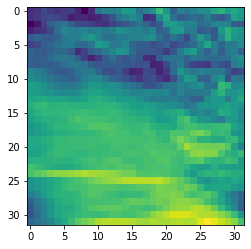

In [ ]:
train_raw = loadmat('drive/My Drive/HW3/train_32x32.mat')
test_raw = loadmat('drive/My Drive/HW3/test_32x32.mat')
train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])


Z = [0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0, 1]
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]


train_labels = train_raw['y']
test_labels = test_raw['y']
train_images = np.moveaxis(train_images, -1, 0)
plt.imshow(train_images[3])
plt.show()
print(train_labels[3])
test_images = np.moveaxis(test_images, -1, 0)
test_positive_patches = []
train_positive_patches = []
train_positive_patches0 = train_images
test_positive_patches0 = test_images

train_images = train_images.astype('float64')
test_images = test_images.astype('float64')
train_images /= 255.0
test_images /= 255.0
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)
print(train_labels[3])

for rgb in train_positive_patches0:
  rgb = rgb2gray(rgb)
  train_positive_patches.append(rgb)

for rgb in test_positive_patches0:
  rgb = rgb2gray(rgb)
  test_positive_patches.append(rgb)

train_positive_patches = np.array(train_positive_patches)
test_positive_patches = np.array(test_positive_patches)


def extract_patches(img, N, scale=1.0, patch_size=(32, 32)):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

images = [color.rgb2grey(getattr(data, name)()) for name in imgs_to_use]

negative_patches = np.vstack([extract_patches(im, 1500, scale)
                        for im in images for scale in [0.5, 1.0, 2.0]])

train_negative_patches = negative_patches[:math.floor(0.8* negative_patches.shape[0])]
test_negative_patches = negative_patches[math.floor(0.8* negative_patches.shape[0]):]

#train_image done

train_images = np.array([im for im in chain(train_positive_patches,
                                            train_negative_patches)])
#test_image done

test_images = np.array([im for im in chain(test_positive_patches,
                                            test_negative_patches)])

#train_labels done

train_labels = np.c_[train_labels, np.zeros(train_labels.shape[0])]
x = train_negative_patches.shape[0]
y = test_negative_patches.shape[0]
for i in range(x):
  train_labels = np.vstack([train_labels, Z])
print(train_labels.shape)

#test_labels done

test_labels = np.c_[test_labels, np.zeros(test_labels.shape[0])]
print(test_labels.shape)
for i in range(y):
  test_labels = np.vstack([test_labels, Z])
plt.imshow(train_images[109256])
print(train_labels[109256])


In [ ]:
# Data augmentation
# Split train data into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels,
                                                  test_size=0.15, random_state=22)

X_train = np.array([X_train])
X_val = np.array([X_val])
X_train = np.moveaxis(X_train, 0, -1)
X_val = np.moveaxis(X_val, 0, -1)
test_images = np.array([test_images])
test_images = np.moveaxis(test_images, 0, -1)
# test_labels = 
# y_train = np.moveaxis(y_train, 0, -1)
# y_val = np.moveaxis(y_val, 0, -1)


datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)
print(test_images.shape)
print(test_labels.shape)


(92868, 32, 32, 1)
(16389, 32, 32, 1)
(92868, 11)
(16389, 11)
(35032, 32, 32, 1)
(35032, 11)


In [ ]:
keras.backend.clear_session()
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 1)),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),   
    keras.layers.Dropout(0.3), 
    keras.layers.Dense(11,  activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)             

In [ ]:
optimizer = keras.optimizers.Adam(lr=1e-3, amsgrad=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(datagen.flow(X_train, y_train),
                              epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
2903/2903 [==============================] - 677s 233ms/step - loss: 0.8624 - accuracy: 0.7206 - val_loss: 0.3265 - val_accuracy: 0.9032
Epoch 2/5
 837/2903 [=======>......................] - ETA: 7:38 - loss: 0.4155 - accuracy: 0.8761

In [ ]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(x=test_images, y=test_labels, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.9151 
Test loss is: 0.3135


In [ ]:
img1 = cv2.imread('drive/My Drive/HW3/14.png', 0)
img2 = cv2.imread('drive/My Drive/HW3/34.png', 0)
img3 = cv2.imread('drive/My Drive/HW3/28.png', 0)
img4 = cv2.imread('drive/My Drive/HW3/32.png', 0)
img5 = cv2.imread('drive/My Drive/HW3/13.png', 0)
img6 = cv2.imread('drive/My Drive/HW3/21.png', 0)
img1_net = np.moveaxis(np.array([img1]), 0, -1)
img2_net = np.moveaxis(np.array([img2]), 0, -1)
img3_net = np.moveaxis(np.array([img3]), 0, -1)
img4_net = np.moveaxis(np.array([img4]), 0, -1)
img5_net = np.moveaxis(np.array([img5]), 0, -1)
img6_net = np.moveaxis(np.array([img6]), 0, -1)

imges = [img1, img2, img3, img4, img5, img6]
print(img1.shape, img2.shape, img3.shape, img4.shape, img5.shape)

(53, 112) (52, 111) (47, 87) (63, 121) (58, 128)


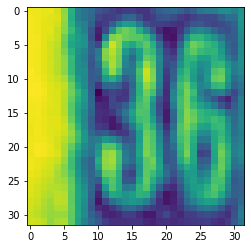

In [ ]:
# Get convolutional layers
layers = [model.get_layer('conv2d_1'), 
          model.get_layer('conv2d_2'),
          model.get_layer('conv2d_3'),
          model.get_layer('conv2d_4')]

# Define a model which gives the outputs of the layers
layer_outputs = [layer.output for layer in layers]
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)

# Create a list with the names of the layers
layer_names = []
for layer in layers:
    layer_names.append(layer.name)

# Define a function which will plot the convolutional filters

def plot_convolutional_filters(img):
    
    img = np.expand_dims(img, axis=0)
    activations = activation_model.predict(img)
    images_per_row = 9
    
    for layer_name, layer_activation in zip(layer_names, activations): 
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): 
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='plasma')
        
img = train_images[42500]
plt.imshow(img)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


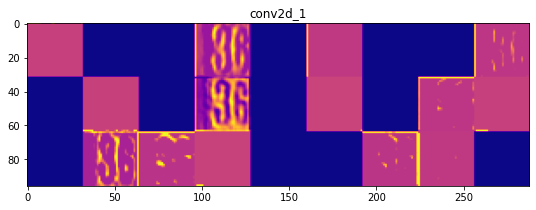

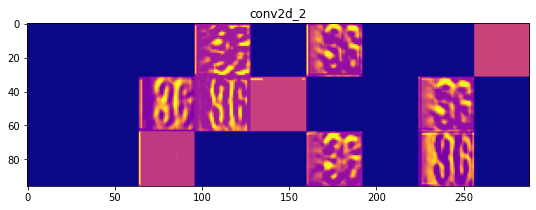

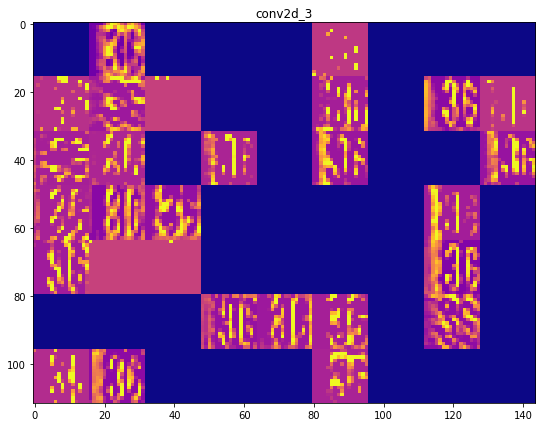

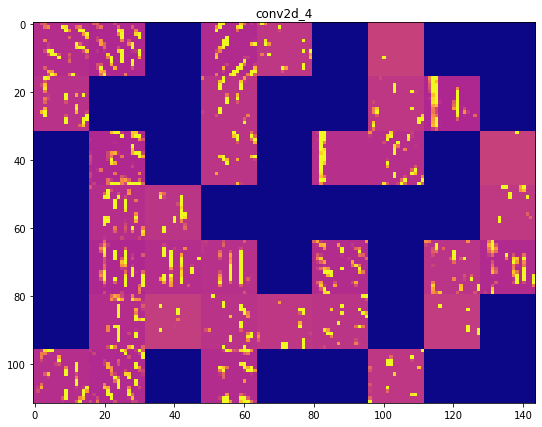

In [ ]:
test_image = np.moveaxis(np.array([train_images[42500]]), 0, -1)
plot_convolutional_filters(test_image)

In [ ]:
%matplotlib inline
from google.colab import files
from IPython.display import Image
from skimage.feature import hog
from matplotlib.pyplot import imshow
from skimage import io
from skimage.transform import pyramid_gaussian


In [ ]:
def pyramid(image):
  if image.shape[0] > 36 and image.shape[1] > 36:
    for (i, resized) in enumerate(pyramid_gaussian(image, downscale=1.1)):
      if resized.shape[0] < 40 or resized.shape[1] < 80:
        break
      else:
        yield resized
  else:
    for (i, resized) in enumerate(pyramid_gaussian(image, downscale=.8)):
      if resized.shape[0] > 50 or resized.shape[1] > 90:
        break
      else:
        yield resized
    
def sliding_window(img, patch_size=(32, 32),
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

a = []
# each image from array can past here to use
for i in pyramid(img6):
  a.append(i)

indices, patches = zip(*sliding_window(a[-1]))
patches = np.array([patch for patch in patches])

predictions = model.predict(np.moveaxis(np.array([patches]), 0, -1))
print(len(indices))

count = 0
for i in range(predictions.shape[0]):
  if (max(predictions[i]) == predictions[i][10]):
    count += 1


135


[[0.9991086, 5, 10], [0.99932384, 5, 37], [0.99954, 5, 64], [0.99919814, 8, 44], [0.9993462, 8, 70], [0.9996259, 8, 124], [0.9996433, 8, 97], [0.9999666, 8, 125], [0.99998856, 8, 71], [0.9999943, 8, 98]]


Text(34, 6, '8')

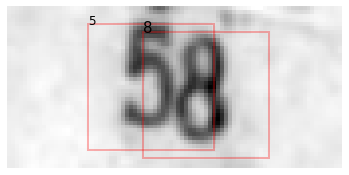

In [ ]:
fig, ax = plt.subplots()
ax.imshow(a[-1], cmap='gray')
ax.axis('off')
Ni, Nj = 32, 32
indices = np.array(indices)
count = []

# nms algorithm was not good for this task and couldn't describe properly
# so i wrote a code for this to use best rectangles for this task

for x in range(predictions.shape[0]):
  if (max(predictions[x])!= predictions[x][10] and max(predictions[x]) > .999):

    max_pred = max(predictions[x])
    index_of_maximum = np.where(predictions[x] == max_pred)
    if index_of_maximum[0][0] == 9:
      count.append([max_pred, 0, x])
    else:
      count.append([max_pred, index_of_maximum[0][0] + 1, x])
      
count.sort(key=lambda x : (x[1], x[0]))
print(count)
font = cv2.FONT_HERSHEY_SIMPLEX

for x in range(len(count) - 1):
  if count[x][1] != count[x+1][1]:
    i, j = indices[count[x][2]]
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                                alpha=0.3, lw=2, facecolor='none'))
    plt.text(j, i, str(count[x][1]), fontsize=12)

# last rectangle certainly belongs to a number whether it is the previous one 
# or the new number

i, j = indices[count[-1][2]]
ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                            alpha=0.3, lw=2, facecolor='none'))
plt.text(j, i, str(count[x][1]), fontsize=15)


nms algorithm is not used in this task because of what I mentioned in previous cell 